# Load Serengeti images into Pytorch

We will be working with the [Snapshot Serengeti](http://lila.science/datasets/snapshot-serengeti) dataset in this tutorial.

The data set that we are pulling images from contains approximately 2.65M sequences of camera trap images, totaling 7.1M images, from the Snapshot Safari network. 
Labels are provided for 61 categories, primarily at the species level (for example, the most common labels are wildebeest, zebra, and Thomson’s gazelle).
Approximately 76% of images are labeled as empty.

This tutorial uses a reduced set of 4000 images, with 1000 images each of 4 species labels: `gazellethomsons`, `giraffe`, `wildebeest`, `zebra`.
If you are following this tutorial as part of a Domino workshop, you should have mounted a Dataset at `/domino/datasets/Serengeti4kImages` containing these 4000 images and corresponding metadata.
Adjust the `data_root_dir` variable below if the data is in a different location.
(See the `admin-setup` folder for details on obtaining the data.)


### Package imports

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Imports for loading data into pytorch
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision import transforms as T

### Read in metadata

Be sure to edit the `data_root_dir` if you have the data in a different location!

Note that we set a random seed when we shuffle the metadata, so that it will give the same results each time.

In [2]:
data_root_dir = '/domino/datasets/Serengeti4kImages'
#data_root_dir = '/domino/datasets/local/Serengeti4kImages'
img_dir = os.path.join(data_root_dir, 'images')
metadata_file = os.path.join(data_root_dir, 'reduced_metadata.csv')

In [3]:
# Read in metadata and ensure it is shuffled
metadata = pd.read_csv(metadata_file).sample(frac=1, random_state=42).reset_index(drop=True)
# Define mappings from label name to index, for 
category_name_to_id = {
    'zebra': 0,
    'giraffe': 1,
    'wildebeest': 2,
    'gazellethomsons': 3
}
category_id_to_name = {v: k for k,v in category_name_to_id.items()}
metadata['category_id'] = metadata['category_name'].apply(lambda x: category_name_to_id[x])
print(f"There are {len(metadata)} images total")
metadata.head()

There are 4000 images total


file_path location  \
0   SER_S11/B03/B03_R1/SER_S11_B03_R1_IMAG0223.JPG      B03   
1   SER_S11/E09/E09_R1/SER_S11_E09_R1_IMAG0512.JPG      E09   
2   SER_S11/O09/O09_R1/SER_S11_O09_R1_IMAG1019.JPG      O09   
3  SER_S11/O07/O07_R1/SER_S11_O07_R1_IMAG02679.JPG      O07   
4   SER_S11/K06/K06_R2/SER_S11_K06_R2_IMAG0650.JPG      K06   

              datetime    category_name                     file_name  \
0  2015-08-19 11:11:10            zebra   SER_S11_B03_R1_IMAG0223.JPG   
1  2015-09-02 12:40:25  gazellethomsons   SER_S11_E09_R1_IMAG0512.JPG   
2  2015-10-31 15:27:34            zebra   SER_S11_O09_R1_IMAG1019.JPG   
3  2015-09-08 11:22:57  gazellethomsons  SER_S11_O07_R1_IMAG02679.JPG   
4  2015-11-08 09:13:59       wildebeest   SER_S11_K06_R2_IMAG0650.JPG   

   category_id  
0            0  
1            3  
2            0  
3            3  
4            2

In [4]:
metadata.value_counts('category_name')

category_name
zebra              1000
wildebeest         1000
giraffe            1000
gazellethomsons    1000
dtype: int64

## PyTorch Datasets
PyTorch provides two data primitives: `DataLoader` and `Dataset`.
Datasets store the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.
To define your own, you need to inherit from the predefined Dataset class and implement three methods:

- `__init__`
- `__len__` so that `len(dataset)` returns the size of the dataset
- `__getitem__` such that `dataset[i]` can be used to get `i`th sample and it's label

See more details in the [pytorch docs](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).
We will eventually be using this data with pretrained models, similar to [this pytorch tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), which will expect image labels to be one-hot encoded, so that is how we return them.

In [5]:
class SnapshotSerengetiDataset(Dataset):
    def __init__(self, img_metadata, img_dir, transform=None):
        # Do some basic validation
        required_columns = ['category_id', 'file_name']
        if not all([x in img_metadata.columns for x in required_columns]):
            raise Exception(f"img_metadata must be a dataframe including columns {', '.join(required_columns)}")
        if not os.path.isdir(img_dir):
            raise Exception("img_dir must be a valid directory")
        self.img_metadata = img_metadata
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_metadata)
        
    def __getitem__(self, idx):
        item_metadata = self.img_metadata.iloc[idx]
        image_path = os.path.join(self.img_dir, item_metadata['file_name'])
        image = read_image(image_path)
        image = torch.mul(image, 1/255.) # scale to [0, 1]
        if self.transform:
            image = self.transform(image)
        label_idx = item_metadata['category_id']
        one_hot_label = (
            torch.zeros(len(category_id_to_name), dtype=torch.float)
            .scatter_(dim=0, index=torch.tensor(label_idx), value=1)
        )
        return image, one_hot_label

### Load and explore the data
Printing the tensor sizes and other intermediate data is one of the easiest ways to confirm that we are prepping the data as we expect.

In [6]:
raw_dataset = SnapshotSerengetiDataset(metadata, img_dir)

In [7]:
#configure some variables for plotting random sample images
sample_figsize = (16, 10)
sample_cols, sample_rows = 3, 2

Feature type: <class 'torch.Tensor'>
Feature shape: torch.Size([3, 1920, 2560])
Label type: <class 'torch.Tensor'>
Label shape: torch.Size([4])
Label contents: tensor([1., 0., 0., 0.])


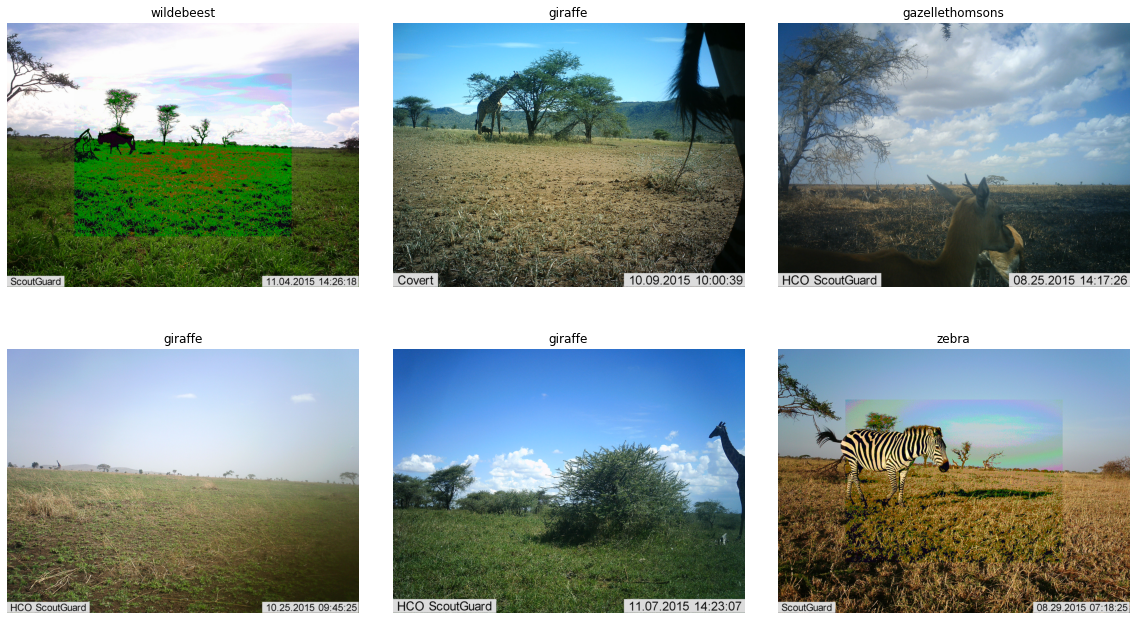

In [8]:
figure = plt.figure(figsize=sample_figsize)
for i in range(sample_cols * sample_rows):
    sample_idx = np.random.randint(len(raw_dataset))
    img, species_label = raw_dataset[sample_idx]
    figure.add_subplot(sample_rows, sample_cols, i+1)
    figure.tight_layout()
    plt.title(category_id_to_name[species_label.argmax().item()])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0))
print(f"Feature type: {type(img)}")
print(f"Feature shape: {img.size()}")
print(f"Label type: {type(species_label)}")
print(f"Label shape: {species_label.size()}")
print(f"Label contents: {species_label}")
plt.show()

## PyTorch Transforms

Data does not always come in its final processed form that is required for training machine learning algorithms.
We use transforms to perform some manipulation of the data and make it suitable for training.

The `torchvision.transforms` module offers several commonly-used transforms out of the box.
The pretrained model we will use in later notebooks will require some standard transformations that we define here.
You'll get to test out some variations at the end of this section.

In [9]:
#These resize and normalize transforms will allow our data to be used with pre-trained networks in later notebooks
standard_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ConvertImageDtype(torch.float32),
    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

### Reload data with transformations and DataLoader
Notice how we can conveniently pass any transformations when initializing the `Dataset`, without rewriting our class definition.

This time, we'll also wrap the `Dataset` in a `DataLoader`, to return batches of images.

In [10]:
transformed_dataset = SnapshotSerengetiDataset(metadata, img_dir, transform=standard_transform)

In [11]:
batch_size = sample_cols*sample_rows
transformed_loader = DataLoader(transformed_dataset, batch_size=batch_size, shuffle=True)
# We'll pass this iterator to the plotting function below, so we can inspect the next batch of images each time
transformed_loader_iter = iter(transformed_loader)

In [12]:
#function to plot sample of transformed images
def show_transformed_images(dataloader_iter, cols=3, rows=3):
    images, species_labels = next(dataloader_iter)
    figure = plt.figure(figsize=sample_figsize)
    print(f"Feature batch shape: {images.size()}")
    print(f"Labels batch shape: {species_labels.size()}")
    for i in range(sample_cols * sample_rows):
        figure.add_subplot(sample_rows, sample_cols, i + 1)
        figure.tight_layout()
        plt.axis("off")
        img = images[i]
        #use since the image is normalized:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img.permute(1, 2, 0).numpy() + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(category_id_to_name[species_labels[i].argmax().item()])
    plt.show()

Feature batch shape: torch.Size([6, 3, 224, 224])
Labels batch shape: torch.Size([6, 4])


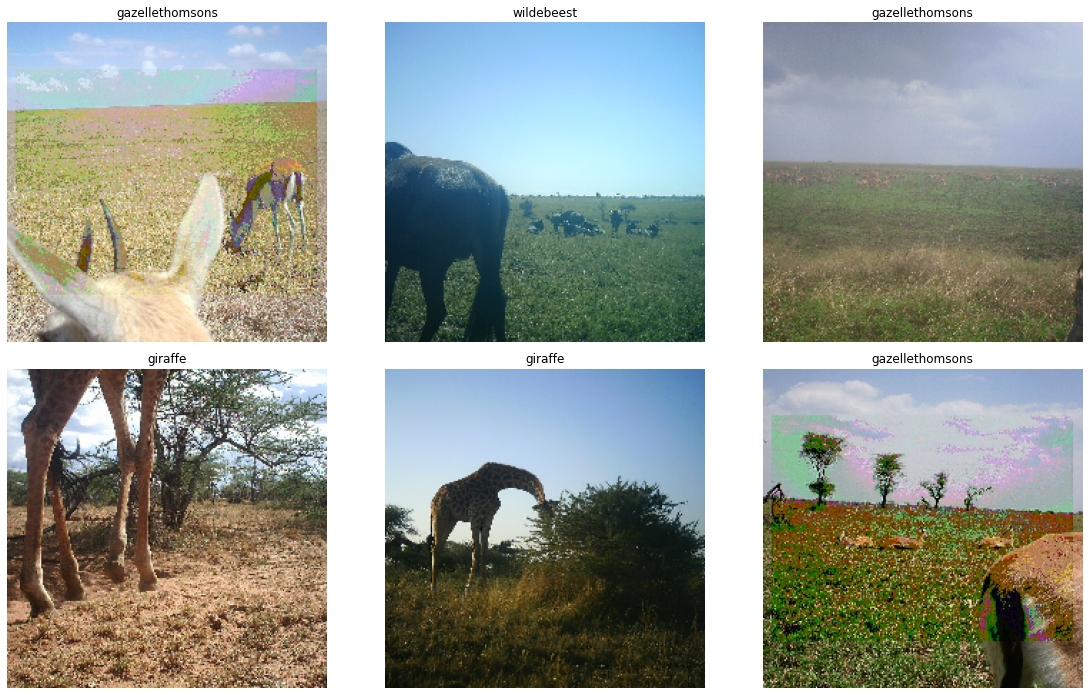

In [13]:
#since we have set this up with the iterator, rerunning this cell will plot the next batch each time
show_transformed_images(transformed_loader_iter)

## Activity: Visualize different PyTorch transforms

See this document on PyTorch transforms - https://pytorch.org/vision/stable/transforms.html

Here is a sample of Pytorch transforms to try out:

- Normalize 
- Resize
- Scale
- CenterCrop
- Pad
- RandomCrop
- RandomHorizontalFlip
- RandomVerticalFlip
- RandomResizedCrop
- RandomSizedCrop
- LinearTransformation
- ColorJitter 
- RandomRotation 
- RandomAffine 
- Grayscale
- RandomGrayscale
- RandomPerspective
- RandomErasing
- GaussianBlur
- InterpolationMode
- RandomInvert 
- RandomPosterize
- RandomSolarize
- RandomAdjustSharpness
- RandomAutocontrast
- RandomEqualize

Test out transforms by adding them to the code below.
Keep the standard transforms in place.

In [14]:
my_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),

    #add transforms here by preceding the transform name with T. For example: 
    T.RandomRotation(30),
                 
    T.ConvertImageDtype(torch.float32),
    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

my_dataset = SnapshotSerengetiDataset(metadata, img_dir, transform=my_transform)
my_loader = DataLoader(my_dataset, batch_size=batch_size, shuffle=True)
my_loader_iter = iter(my_loader)

Feature batch shape: torch.Size([6, 3, 224, 224])
Labels batch shape: torch.Size([6, 4])


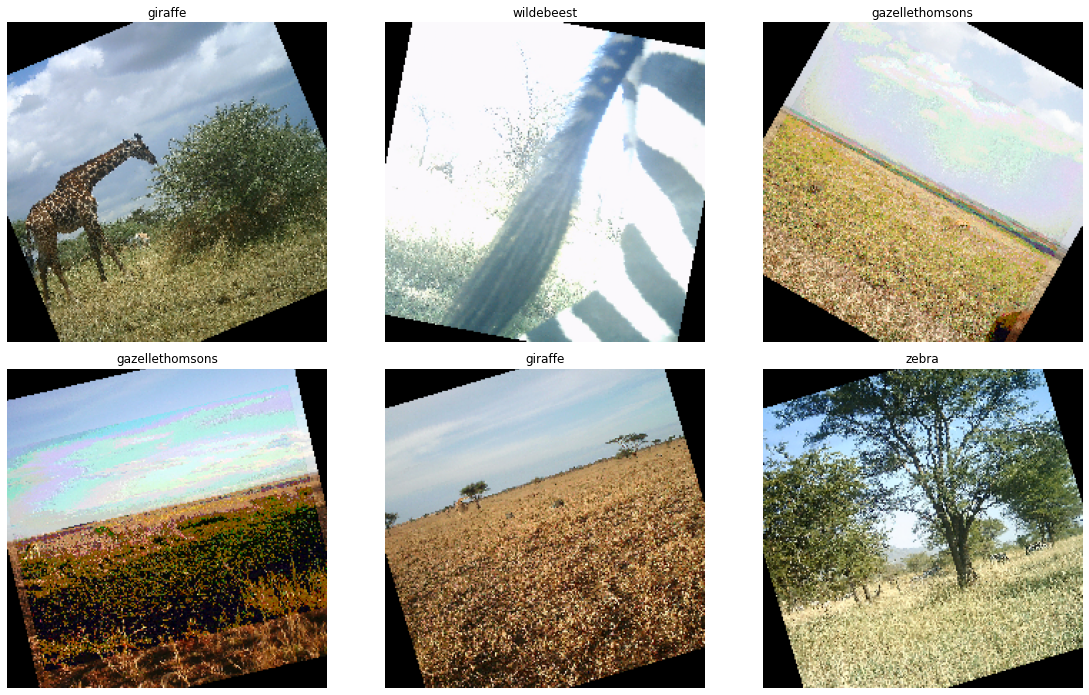

In [15]:
# As above, you can run this cell multiple times to see the next batch each time
show_transformed_images(my_loader_iter)